## Importing libraries

In [7]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.optimizers import Adam
import scipy.io
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models, optimizers
from PIL import Image, ImageOps

## Reading data

In [12]:
def load_dataset(image_dir, gt_dir, target_size=(224, 224)):
    X = []
    y = []
    c = 0
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    image_files.sort()  # opcjonalnie

    if not image_files:
        raise ValueError("Brak plików .jpg w podanym katalogu!")

    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        mat_path = os.path.join(gt_dir, 'GT_' + img_file.replace('.jpg', '.mat'))

        # Wczytaj i przeskaluj obraz do dokładnego rozmiaru target_size (bez paddingu)
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize(target_size, Image.LANCZOS)

        # Konwersja do numpy + preprocess_input (dla MobileNet)
        img_array = np.array(img_resized, dtype=np.float32)
        img_array = preprocess_input(img_array)

        # Wczytaj ground truth (liczba osób)
        mat = scipy.io.loadmat(mat_path)
        count = len(mat['image_info'][0][0][0][0][0])

        X.append(img_array)
        y.append(count)
        # if c == 1:
        #     plt.imshow(img_resized)
        #     print(img_path)
        #     print(count)
        #     break
        # c += 1

    return np.array(X), np.array(y)

## Getting the training set and the test set

In [9]:
X_train, y_train = load_dataset('ShanghaiTech/part_B/train_data/images/', 'ShanghaiTech/part_B/train_data/ground-truth/')

In [13]:
X_test, y_test = load_dataset('ShanghaiTech/part_B/test_data/images/', 'ShanghaiTech/part_B/test_data/ground-truth/')

## Building the model

In [15]:
base_model = MobileNet(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Zamroź warstwy

# base_model.trainable = True
# for layer in base_model.layers[:-30]:
#     layer.trainable = False

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


model.compile(optimizer=Adam(1e-4), loss='mse', metrics=['mae'])

ERROR! Session/line number was not unique in database. History logging moved to new session 1850


## Data augmentation and training the model

In [16]:
# Function to augment
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

training_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
training_set = training_set.map(augment)  # augment
training_set = training_set.batch(32).prefetch(tf.data.AUTOTUNE)
history = model.fit(training_set, batch_size=32,
    epochs=20, shuffle=True, validation_data=(X_test, y_test)
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 18828.5723 - mae: 102.9259 - val_loss: 8733.6592 - val_mae: 72.0544
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 8765.1445 - mae: 74.6761 - val_loss: 8045.8765 - val_mae: 68.2239
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 7617.8740 - mae: 65.2316 - val_loss: 7716.7090 - val_mae: 59.7988
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 7193.0381 - mae: 60.8509 - val_loss: 6991.3354 - val_mae: 58.1457
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 6712.4463 - mae: 59.5413 - val_loss: 6519.9395 - val_mae: 55.5010
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 6223.5244 - mae: 56.8385 - val_loss: 6269.7681 - val_mae: 51.9355
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 6188.3730 - mae: 56.6535 - val_loss: 6016.3970 - val_mae: 49.6283
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 5467.9912 - mae: 51.7231 - val_loss: 5765.9102 - val_mae: 47.8756
Epoch 

## Training curves visualisation

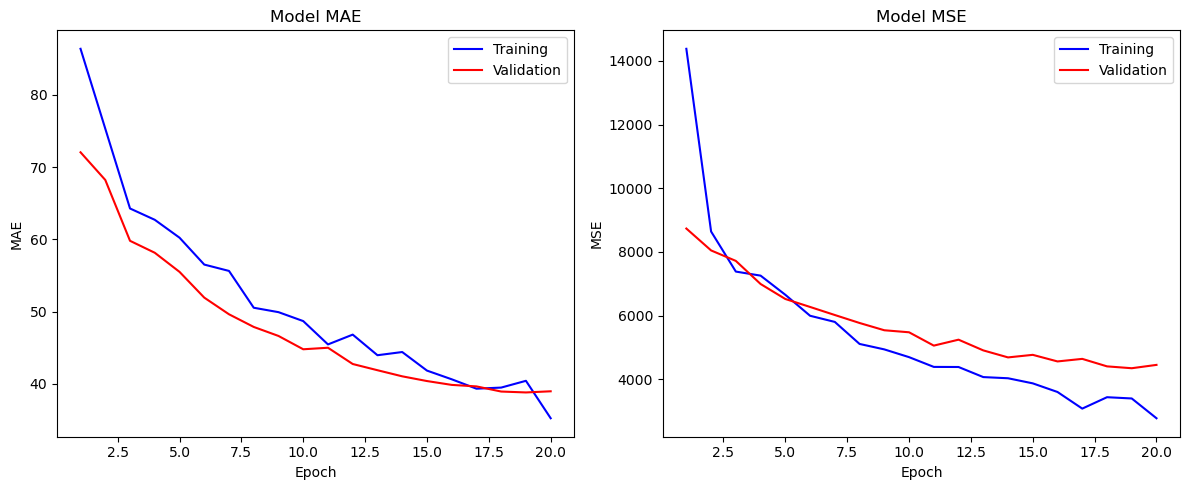

In [17]:
history_dict = history.history

# Getting the metrics
mae = history_dict['mae']
val_mae = history_dict.get('val_mae')
loss = history_dict['loss']
val_loss = history_dict.get('val_loss')

epochs = range(1, len(mae) + 1)

# MAE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, mae, 'b-', label='Training')
if val_mae:
    plt.plot(epochs, val_mae, 'r-', label='Validation')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Loss (MSE)
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training')
if val_loss:
    plt.plot(epochs, val_loss, 'r-', label='Validation')
plt.title('Model MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


## Making predictions

In [18]:
y_pred = np.round(model.predict(X_test))

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 568ms/step


In [19]:
y_pred.reshape(len(y_pred), 1)
y_test.reshape(len(y_test), 1)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))

[[ 17.  23.]
 [184. 181.]
 [162. 157.]
 [ 40.  37.]
 [102.  70.]
 [ 68.  57.]
 [ 30.  44.]
 [191. 227.]
 [147. 165.]
 [210. 476.]
 [103. 139.]
 [189. 316.]
 [137. 164.]
 [124. 110.]
 [ 38.  20.]
 [174. 131.]
 [ 52.  48.]
 [147. 183.]
 [129. 101.]
 [172. 204.]
 [ 30.  40.]
 [104. 143.]
 [176. 146.]
 [201. 513.]
 [ 38.  70.]
 [ 77. 175.]
 [ 21.  51.]
 [ 61.  55.]
 [ 90.  67.]
 [ 54.  72.]
 [ 25.  56.]
 [142. 165.]
 [ 21.  32.]
 [142. 149.]
 [ 38.  48.]
 [104.  80.]
 [107. 117.]
 [ 59. 162.]
 [153. 137.]
 [116. 120.]
 [ 91.  72.]
 [137. 122.]
 [173. 198.]
 [104. 133.]
 [103. 147.]
 [ 31.  29.]
 [ 35.  70.]
 [ 16.  35.]
 [ 46.  24.]
 [163. 251.]
 [ 38.  59.]
 [144.  67.]
 [ 41.  61.]
 [185. 248.]
 [216. 252.]
 [189. 147.]
 [ 27.  57.]
 [116. 121.]
 [ 59.  47.]
 [220. 505.]
 [168. 297.]
 [179. 465.]
 [114. 167.]
 [ 30.  43.]
 [ 36.  46.]
 [108.  91.]
 [177. 263.]
 [ 97.  92.]
 [ 73. 117.]
 [ 41.  48.]
 [ 69.  54.]
 [ 87.  73.]
 [ 92. 122.]
 [ 91.  60.]
 [221. 170.]
 [105. 167.]
 [ 38.  57.]

## Metrics

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
print("R2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", root_mean_squared_error(y_test, y_pred))

R2: 0.5085470676422119
MSE: 4447.7216796875
MAE: 38.97468185424805
RMSE: 66.69123840332031
